<a href="https://colab.research.google.com/github/CSEK19/Calories/blob/main/Food_Recognition_Mask_RCNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')\

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Create folder data
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
# Copy data from drive
!cp /content/drive/MyDrive/Data/train-v0.4.tar.gz data/train-v0.4.tar.gz
# !cp /content/drive/MyDrive/Data/test_images-v0.4.tar.gz data/test_images-v0.4.tar.gz

In [4]:
%cd data/

/content/data


In [ ]:
!for f in *.tar.gz; do tar xf "$f"; done

In [6]:
%cd ..

/content


# **Preprocessing data**

In [ ]:
!git clone https://gitlab.aicrowd.com/nikhil_rayaprolu/food-recognition/

In [1]:
%cd food-recognition/

/content/food-recognition


In [ ]:
!pip install -r requirements.txt

In [ ]:
!python setup.py install

In [4]:
%cd ..

/content


In [2]:
import glob
import os
import pandas as pd
from collections import OrderedDict
from collections import defaultdict, Counter
from imgaug import augmenters as iaa
from matplotlib.patches import Polygon

# Import Mask RCNN
import mrcnn.model as modellib
from mrcnn import utils
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn.model import log
from mrcnn.visualize import display_images

from pycocotools import mask as maskUtils
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tqdm import tqdm
import cv2
import itertools
import json
import logging
import math
import matplotlib
import matplotlib.lines as lines
import matplotlib.patches as patches
import matplotlib.pyplot as plt

import numpy as np
import random
import re
import sys

ROOT_DIR = os.path.abspath(".") # Root directory of the project

sys.path.append(os.path.join('.', 'Mask_RCNN')) 
sys.path.append(ROOT_DIR)  # To find local version of the library

In [11]:
%cd data/

/content/data


In [9]:
class FoodChallengeDataset(utils.Dataset):
    def load_dataset(self, dataset_dir, load_small=False, return_coco=True):
        """ Loads dataset released for the AICrowd Food Challenge
            Params:
                - dataset_dir : root directory of the dataset (can point to the train/val folder)
                - load_small : Boolean value which signals if the annotations for all the images need to be loaded into the memory,
                               or if only a small subset of the same should be loaded into memory
        """
        self.load_small = load_small
        if self.load_small:
            annotation_path = os.path.join(dataset_dir, "annotation-small.json")
        else:
            annotation_path = os.path.join(dataset_dir, "annotations.json")

        image_dir = os.path.join(dataset_dir, "images")
        print("Annotation Path ", annotation_path)
        print("Image Dir ", image_dir)
        assert os.path.exists(annotation_path) and os.path.exists(image_dir)

        self.coco = COCO(annotation_path)
        self.image_dir = image_dir

        # Load all classes (Only Building in this version)
        classIds = self.coco.getCatIds()

        # Load all images
        image_ids = list(self.coco.imgs.keys())

        # register classes
        for _class_id in classIds:
            self.add_class("crowdai-food-challenge", _class_id, self.coco.loadCats(_class_id)[0]["name"])

        # Register Images
        for _img_id in image_ids:
            assert(os.path.exists(os.path.join(image_dir, self.coco.imgs[_img_id]['file_name'])))
            self.add_image(
                "crowdai-food-challenge", image_id=_img_id,
                path=os.path.join(image_dir, self.coco.imgs[_img_id]['file_name']),
                width=self.coco.imgs[_img_id]["width"],
                height=self.coco.imgs[_img_id]["height"],
                annotations=self.coco.loadAnns(self.coco.getAnnIds(
                                            imgIds=[_img_id],
                                            catIds=classIds,
                                            iscrowd=None)))

        if return_coco:
            return self.coco

    def load_mask(self, image_id):
        """ Loads instance mask for a given image
              This function converts mask from the coco format to a
              a bitmap [height, width, instance]
            Params:
                - image_id : reference id for a given image

            Returns:
                masks : A bool array of shape [height, width, instances] with
                    one mask per instance
                class_ids : a 1D array of classIds of the corresponding instance masks
                    (In this version of the challenge it will be of shape [instances] and always be filled with the class-id of the "Building" class.)
        """

        image_info = self.image_info[image_id]
        assert image_info["source"] == "crowdai-food-challenge"

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "crowdai-food-challenge.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation,  image_info["height"],
                                                image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue

                # Ignore the notion of "is_crowd" as specified in the coco format
                # as we donot have the said annotation in the current version of the dataset

                instance_masks.append(m)
                class_ids.append(class_id)
        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(FoodChallengeDataset, self).load_mask(image_id)


    def image_reference(self, image_id):
        """Return a reference for a particular image

            Ideally you this function is supposed to return a URL
            but in this case, we will simply return the image_id
        """
        return "crowdai-food-challenge::{}".format(image_id)
    # The following two functions are from pycocotools with a few changes.

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

In [12]:
# From mrcnn.dataset import FoodChallengeDataset
dataset_train = FoodChallengeDataset()
# dataset_train.load_dataset(dataset_dir=os.path.join("content/train", "train"), load_small=False)
dataset_train.load_dataset(dataset_dir="train", load_small=False)
dataset_train.prepare()
dataset = dataset_train

Annotation Path  train/annotations.json
Image Dir  train/images
loading annotations into memory...
Done (t=1.95s)
creating index...
index created!


In [13]:
print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))

Image Count: 24119
Class Count: 274


In [27]:
from mrcnn.config import Config
class FoodChallengeConfig(Config):
    """Configuration for training on data in MS COCO format.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "crowdai-food-challenge"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Uncomment to train on 8 GPUs (default is 1)
    GPU_COUNT = 1
    BACKBONE = 'resnet50'
    # Number of classes (including background)
    NUM_CLASSES = 274  # 1 Background + 273 classes

    STEPS_PER_EPOCH= 2
    VALIDATION_STEPS= 2

    LEARNING_RATE=0.001
    IMAGE_MAX_DIM=256
    IMAGE_MIN_DIM=256
config = FoodChallengeConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                286
IMAGE_MIN_DIM                  256
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           crowdai-food-challenge
NUM_CLASSES                    274
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE

# **Data discovery**


In [ ]:
from collections import Counter
class_counts = Counter()
for img_info in dataset_train.image_info:
    ann = img_info['annotations']
    for i in ann:
        class_counts[i['category_id']] += 1
class_mapping = {i['id']: i['name'] for i in dataset_train.class_info}

class_counts = pd.DataFrame(class_counts.most_common(), columns=['class_name', 'count'])
class_counts['class_name'] = class_counts['class_name'].apply(lambda x: class_mapping[x])
plt.figure(figsize=(12, 12))
plt.barh(class_counts['class_name'], class_counts['count'])
plt.title('Counts of classes of objects');

In [ ]:
print(f'There are {class_counts.shape[0]} classes.')

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, figsize=(12, 12))

In [ ]:
dataset_train.image_info[0]

# **Mask**

In [ ]:
class_images = defaultdict(list)
for ind, img_info in enumerate(dataset_train.image_info):
    ann = img_info['annotations']
    for i in ann:
        class_images[i['category_id']].append(ind)

In [ ]:
image_ids = np.random.choice(dataset.image_ids, 4)
for class_id in np.random.choice(list(class_images.keys()), 10):
    image_id = np.random.choice(class_images[class_id], 1)[0]
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Bounding Boxes

In [ ]:
for idx, class_id in enumerate(np.random.choice(list(class_images.keys()), 10)):
    image_id = np.random.choice(class_images[class_id], 1)[0]
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    # Compute Bounding box
    bbox = utils.extract_bboxes(mask)
    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, figsize=(8, 8))

# **Anchors**

In [ ]:
# Generate Anchors

backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

In [ ]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

In [ ]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [ ]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

In [ ]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

In [ ]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

In [ ]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

# **ROIs**

In [ ]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

In [ ]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [ ]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

# **Training the Mask RCNN model (Tensorflow)**

In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall

In [ ]:
!pip install -U scikit-image==0.16.2

In [15]:
%cd ..

/content


In [ ]:
!mkdir pretrained

In [4]:
PRETRAINED_MODEL_PATH = os.path.join("pretrained", "mask_rcnn_coco.h5")
LOGS_DIRECTORY = os.path.join(ROOT_DIR, "logs")
if not os.path.exists(PRETRAINED_MODEL_PATH):
    utils.download_trained_weights(PRETRAINED_MODEL_PATH)

In [6]:
import tensorflow.compat.v1 as tf


In [7]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [ ]:
import keras.backend
K = keras.backend.backend()
if K=='tensorflow':
    keras.backend.common.image_dim_ordering()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=LOGS_DIRECTORY)
model_path = PRETRAINED_MODEL_PATH
model.load_weights(model_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [18]:
%cd data/

/content/data


In [19]:
dataset_train = FoodChallengeDataset()
dataset_train.load_dataset(dataset_dir="train", load_small=False)
dataset_train.prepare()

Annotation Path  train/annotations.json
Image Dir  train/images
loading annotations into memory...
Done (t=2.11s)
creating index...
index created!


In [20]:
dataset_val = FoodChallengeDataset()
val_coco = dataset_val.load_dataset(dataset_dir='/content/data/val', load_small=False, return_coco=True)
dataset_val.prepare()

Annotation Path  /content/data/val/annotations.json
Image Dir  /content/data/val/images
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [21]:
class_names = dataset_train.class_names
assert len(class_names)==274, "Please check DatasetConfig"

In [28]:
print("Training network")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=2,   
            layers='heads')

Training network

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/crowdai-food-challenge20211202T0455/mask_rcnn_crowdai-food-challenge_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessi

Epoch 1/2
49/50 [============================>.] - ETA: 58s - loss: 2.8577 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 0.5894 - mrcnn_class_loss: 0.6823 - mrcnn_bbox_loss: 0.8039 - mrcnn_mask_loss: 0.7532 

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


50/50 [==============================] - 3510s 70s/step - loss: 2.8459 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.5790 - mrcnn_class_loss: 0.6830 - mrcnn_bbox_loss: 0.8036 - mrcnn_mask_loss: 0.7517 - val_loss: 2.5759 - val_rpn_class_loss: 0.0232 - val_rpn_bbox_loss: 0.4771 - val_mrcnn_class_loss: 0.6226 - val_mrcnn_bbox_loss: 0.7529 - val_mrcnn_mask_loss: 0.7002

Epoch 2/2
50/50 [==============================] - 3464s 69s/step - loss: 2.3828 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.6408 - mrcnn_class_loss: 0.3706 - mrcnn_bbox_loss: 0.6660 - mrcnn_mask_loss: 0.6886 - val_loss: 2.5763 - val_rpn_class_loss: 0.0239 - val_rpn_bbox_loss: 0.7897 - val_mrcnn_class_loss: 0.4516 - val_mrcnn_bbox_loss: 0.6247 - val_mrcnn_mask_loss: 0.6864


In [29]:
model_path = model.find_last()
model_path

('/content/logs/crowdai-food-challenge20211202T0455',
 '/content/logs/crowdai-food-challenge20211202T0455/mask_rcnn_crowdai-food-challenge_0001.h5')

In [30]:
model_path = '/content/logs/crowdai-food-challenge20211202T0455/mask_rcnn_crowdai-food-challenge_0001.h5'

In [31]:
class InferenceConfig(FoodChallengeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 274  # 1 Background + 273 classes
    IMAGE_MAX_DIM=256
    IMAGE_MIN_DIM=256
    NAME = "food"
    DETECTION_MIN_CONFIDENCE=0

inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                286
IMAGE_MIN_DIM                  256
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           food
NUM_CLASSES                    274
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NM

In [32]:
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/logs/crowdai-food-challenge20211202T0455/mask_rcnn_crowdai-food-challenge_0001.h5


(256, 256, 3)


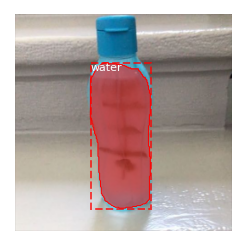

[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0

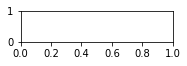

(256, 256, 3)


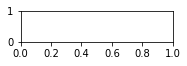

[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0

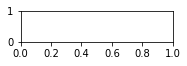

(256, 256, 3)


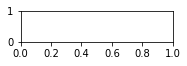

[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0

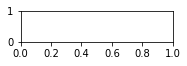

(256, 256, 3)


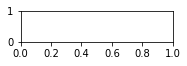

[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0

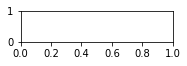

In [34]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(4):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names, ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=fig.axes[-1])